# Compare methods notebook

In [1]:
import glob
import os
import gzip
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from result_classes import Result,MethodResults

In [2]:
prob_name = "long_Calcium_Oscillate"
methods = ["ptmcmc", "smc", "pmc"]

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		with gzip.open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)		

## Calculate the percentage of runs that converged in PT-MCMC

92 of 100 runs have converged
Convergence fraction: 0.92


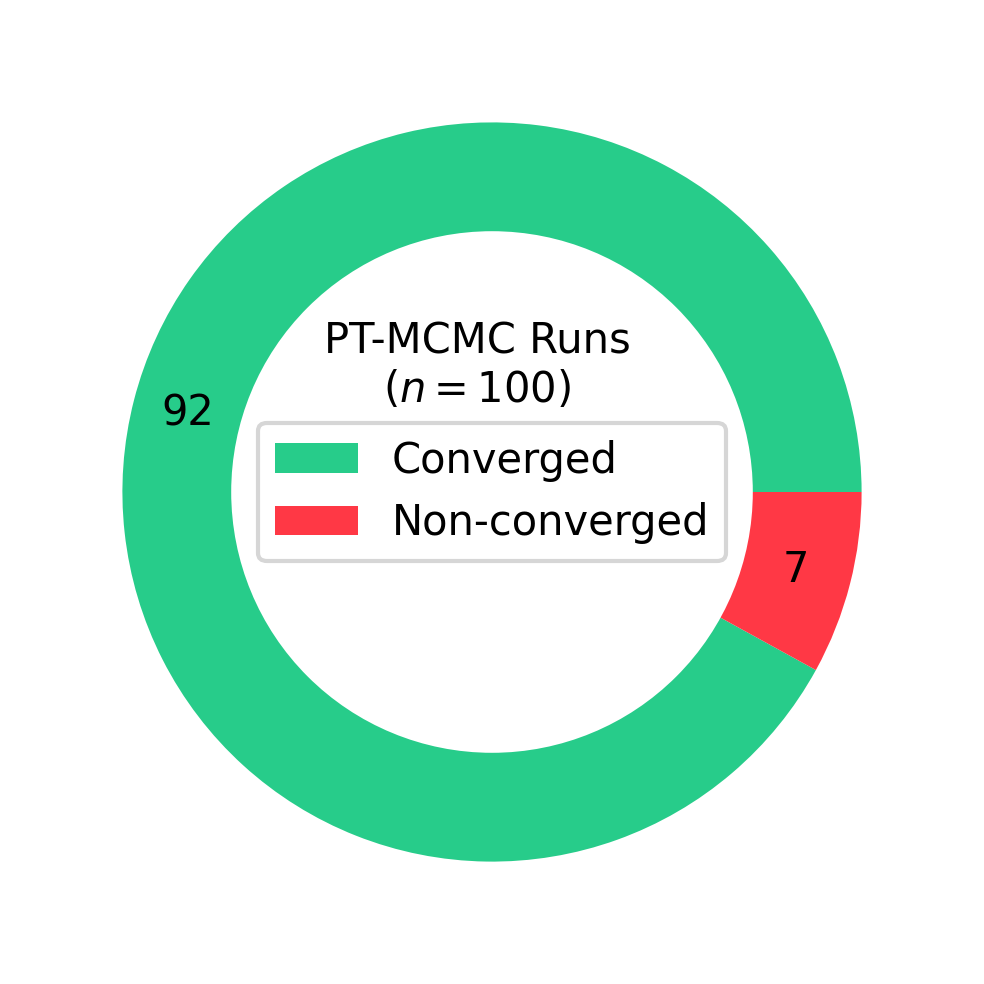

In [3]:
try:
	ptmcmc_idx = methods.index("ptmcmc")
	ptmcmc_group = grouped_results[ptmcmc_idx]
	n_runs = len(ptmcmc_group.all_runs)
	n_converged = 0
	for i in range(n_runs):
		#print(ptmcmc_group.all_runs[i].algo_specific_info["burn_in_idx"])
		#print(ptmcmc_group.all_runs[i].posterior_llhs)
		#print(ptmcmc_group.all_runs[i].n_iter)
		#print(ptmcmc_group.all_runs[i].n_chains)
		#print(ptmcmc_group.all_runs[i].seed, "\t", ptmcmc_group.all_runs[i].converged)
		#break
		if ptmcmc_group.all_runs[i].converged:
			n_converged+=1
	print(f"{n_converged:d} of {n_runs:d} runs have converged\nConvergence fraction: {n_converged/n_runs:.2f}")
	fig = plt.figure(figsize=(4,4), dpi=300)
	colors = ["#27cc8a", "#ff3845"]
	# Create a pie plot
	plt.pie([n_converged, (n_runs-n_converged)], autopct='%d',
			colors=colors, pctdistance=0.85)

	# add a white circle at the center
	my_circle=plt.Circle((0,0), 0.7, color='white')
	fig.gca().add_artist(my_circle)
	#text = f"{100*n_converged/n_runs:.2f}%\nPT-MCMC\nconvergence"
	text = f"PT-MCMC Runs\n($n={n_runs}$)"
	plt.figtext(0.5, 0.6, text, ha='center', va='center')
	plt.legend(labels=["Converged", "Non-converged"], loc="center");

except ValueError:
	pass

## Plot the distribution of ALL likelihoods from ALL runs

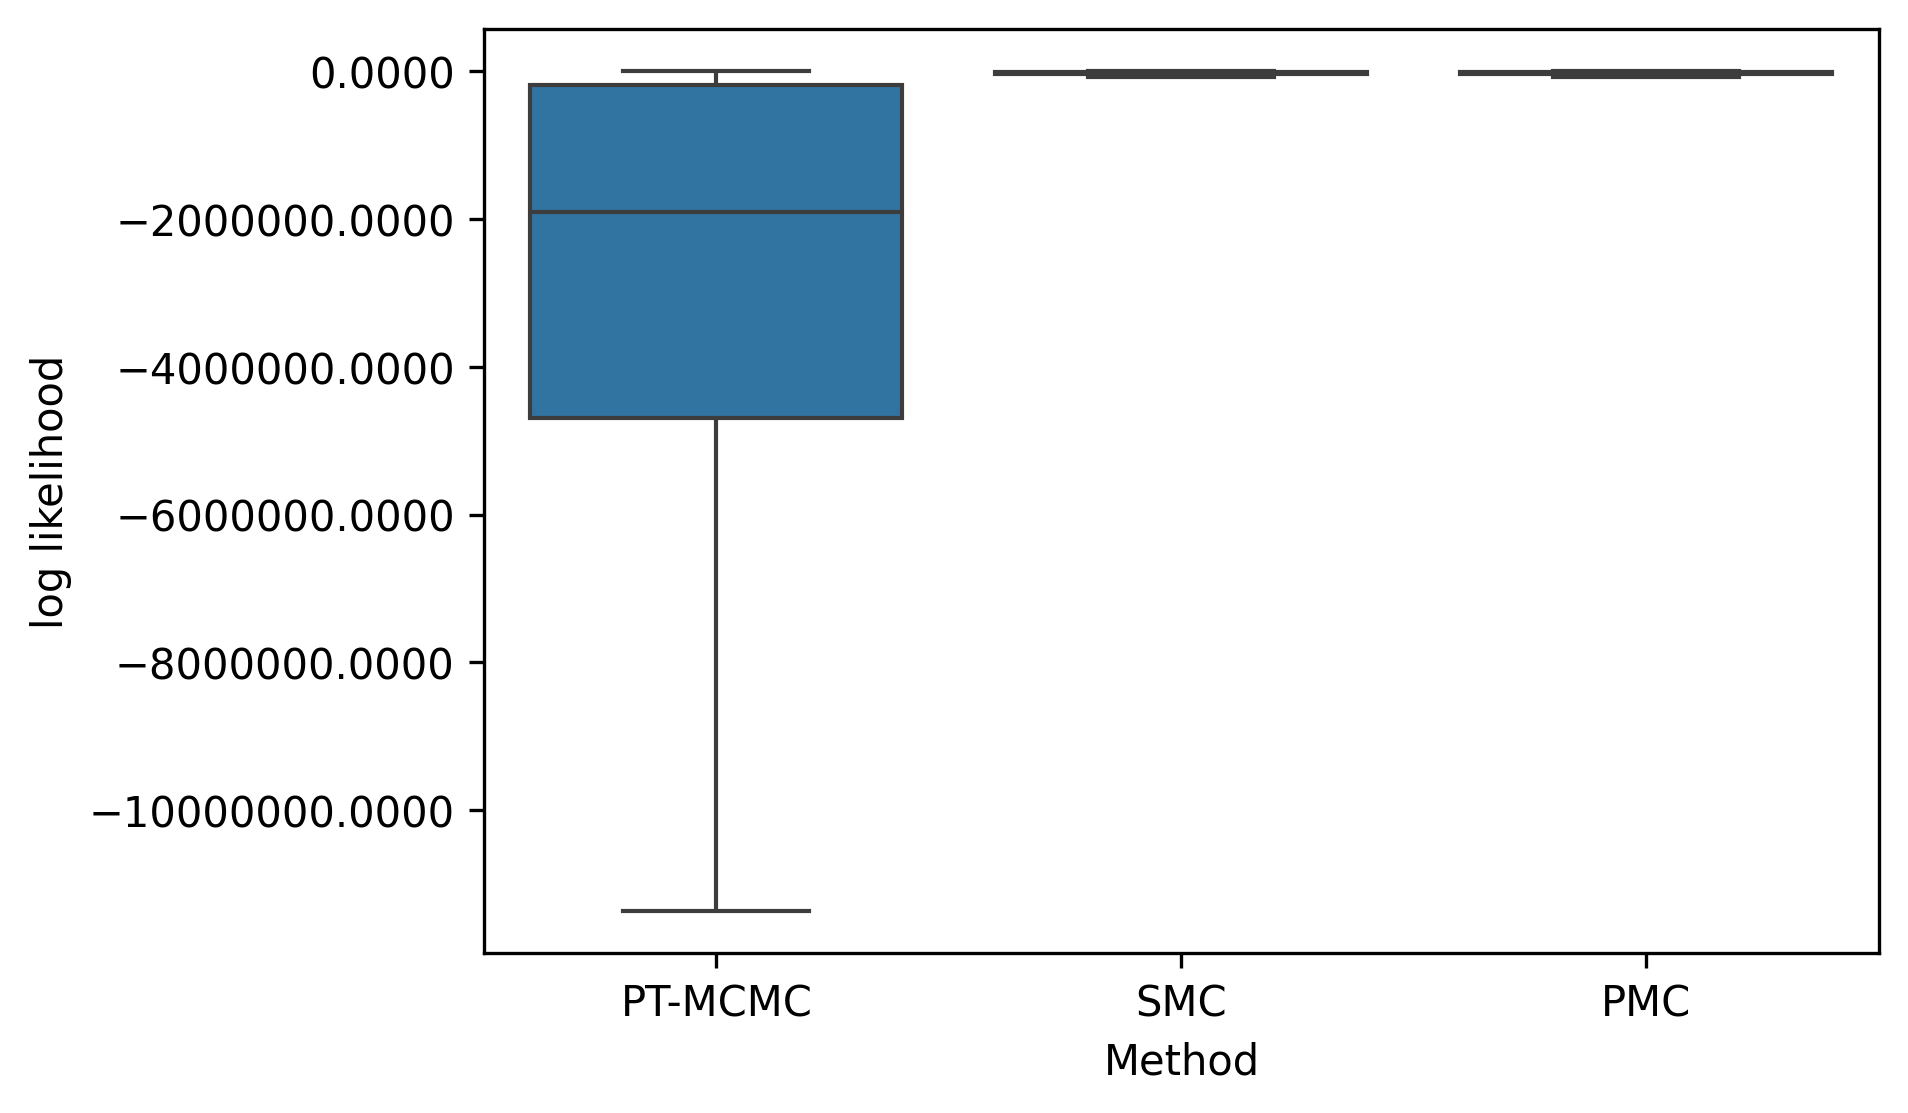

In [4]:
plt.figure(dpi=300, figsize=(6,4))
llhs = np.array([x.get_llhs().flatten() for x in grouped_results], dtype=object)

#llhs[llhs<-20000] = -7500
llh_df = pd.DataFrame()
for llh_arr, method in zip(llhs, methods):
	temp_df = pd.DataFrame()
	temp_df[method] = llh_arr
	llh_df = pd.concat([llh_df, temp_df])

sns.boxplot(llh_df, showfliers=False)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel("log likelihood");
plt.gca().yaxis.set_major_formatter("{x:.4f}")

MAX NUM FUNC CALLS: 14710000.0
3405688.782608696
5708500.0
4801302.8965517245


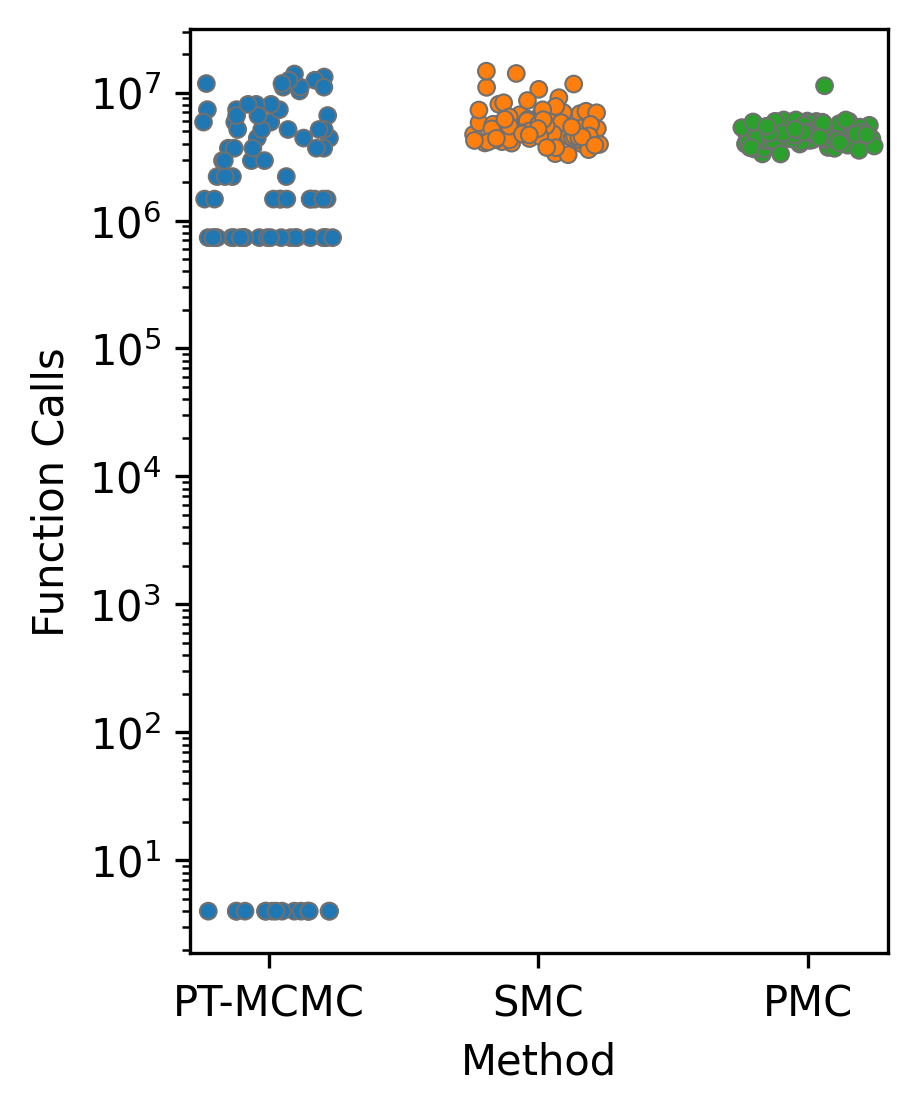

In [5]:
plt.figure(dpi=300, figsize=(3,4))
calls = np.array([x.get_fun_calls() for x in grouped_results], dtype=object)

call_df = pd.DataFrame()
for call_arr, method in zip(calls, methods):
	temp_df = pd.DataFrame()
	temp_df[method] = call_arr
	call_df = pd.concat([call_df, temp_df])

#sns.violinplot(call_df, inner=None)
#sns.swarmplot(call_df, color="#505050",edgecolor="#505050", linewidth=0.5, s=2)
sns.stripplot(call_df, edgecolor="#707070", linewidth=0.5, s=4, jitter=0.25)
plt.margins(x=0.02)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel("Function Calls");
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.yscale("log")
print(f"MAX NUM FUNC CALLS: {np.max([max(x) for x in calls])}")
#plt.gca().yaxis.set_major_formatter("{x:.0f}")
for x in calls:
	print(np.nanmean(x))

ptmcmc AVERAGE: 14710004.0
smc AVERAGE: 5708500.0
pmc AVERAGE: 4797206.8965517245


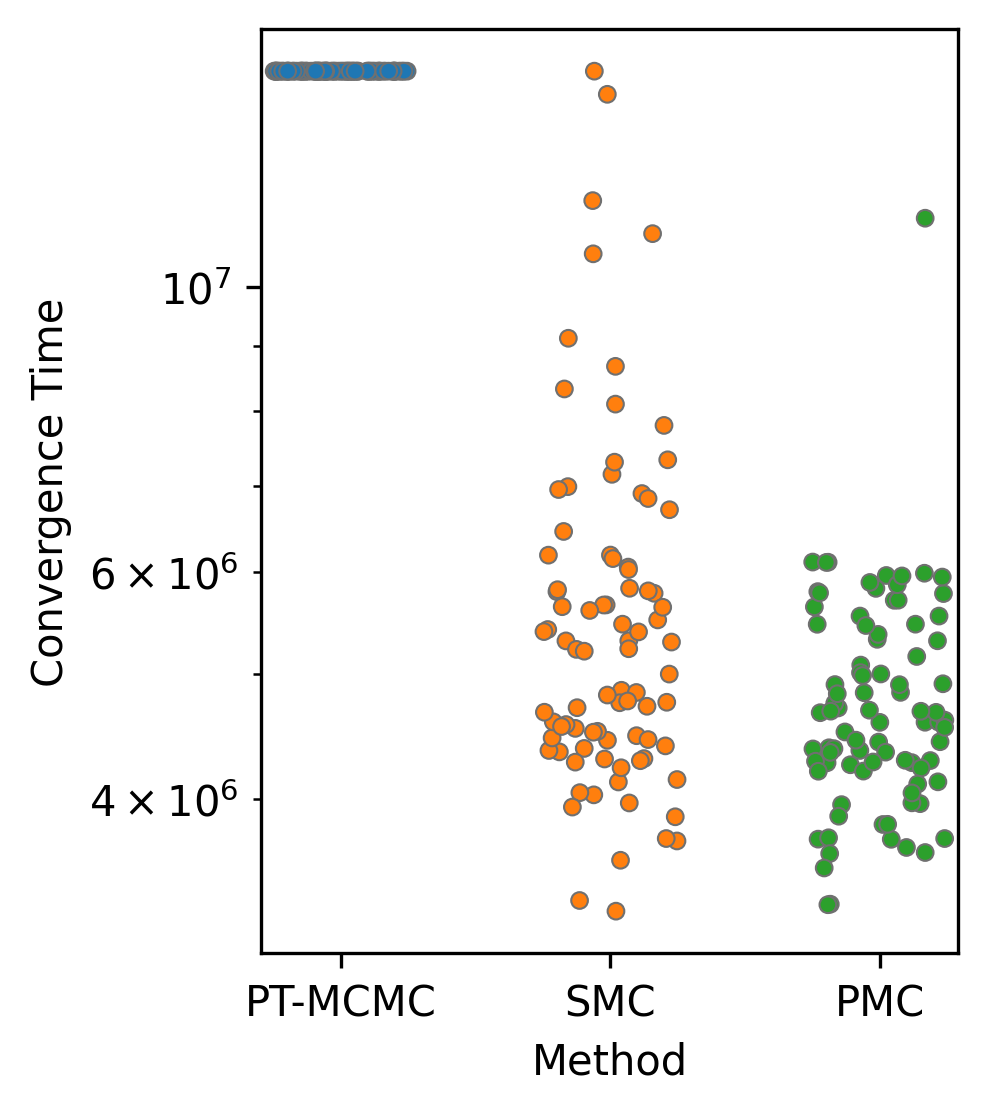

In [6]:
llh_threshold = -11
plt.figure(dpi=300, figsize=(3,4))
#grouped_results[0].get_convergence_times(llh_threshold)
conv = np.array([x.get_convergence_times(llh_threshold) for x in grouped_results], dtype=object)
conv_df = pd.DataFrame()

init_llhs = np.array([x.get_best_inits() for x in grouped_results], dtype=object)
init_llhs_df = pd.DataFrame()

for conv_arr, llh_arr, method in zip(conv, init_llhs, methods):
	temp_df = pd.DataFrame()
	temp_df[method] = conv_arr
	conv_df = pd.concat([conv_df, temp_df])
	print(f"{method} AVERAGE: {np.nanmean(conv_arr)}")

	tmp_df = pd.DataFrame()
	tmp_df[method] = llh_arr
	init_llhs_df = pd.concat([init_llhs_df, tmp_df])

#sns.violinplot(conv_df, inner=None, bw_method=0.1, common_norm=False)
sns.stripplot(conv_df, edgecolor="#707070", linewidth=0.5, s=4, jitter=0.25)
plt.margins(x=0.02)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); 
plt.ylabel("Convergence Time");
plt.yscale("log")

In [7]:
iters = grouped_results[0].all_runs[0].n_iter
chs = grouped_results[0].all_runs[0].n_chains
fix_conv = [iters*chs if x!=x else x for x in conv[0,:]]
conv_mask = ["o" if x.converged else "X" for x in grouped_results[0].all_runs]
color_mask = ["tab:blue" if x.converged else "r" for x in grouped_results[0].all_runs]

fig, axs = plt.subplots(1, 3, dpi=300, figsize=(12,4))

for x,y,m,c in zip(-1*init_llhs[0,:], fix_conv, conv_mask, color_mask):
	axs[0].scatter(x, y, marker=m, color=c, 
				edgecolor="#707070", linewidth=0.4)
axs[0].set_yscale("log"); 
axs[0].set_xscale("log")
axs[0].set_xlabel(r"Best initial sample based on $-\mathcal{L}$")
axs[0].set_ylabel("Convergence Time");
axs[0].set_title("PT-MCMC")

if prob_name == "Neg_Feed_Oscillate":
	from matplotlib.ticker import StrMethodFormatter, NullFormatter
	axs[0].xaxis.set_minor_formatter(NullFormatter())
	axs[0].yaxis.set_minor_formatter(NullFormatter())
	axs[0].set_xticks([1.935*(1e1), 1.95*(1e1), 1.975*1e1])

if prob_name == "Shp2":
	axs[0].set_yticks([5*1e4, 6*1e4, 7*1e4, 8*1e4, 9*1e4, 1e5, 1.25*1e5], 
						[r"$5\times10^4$", r"$6\times10^4$", r"$7\times 10^4$", 
						r"$8\times10^4$", r"$9\times10^4$", r"$10^5$", r"$1.25\times10^5$"],
						minor=True)
	axs[0].set_ylim(bottom=4.9*1e4, top=1.25*1e5)
	#axs[0].set_xticks([1.102728*1e1, 1.102727*1e1, 1.102729*1e1], 
	#					[r"$11.02728$", r"$11.02727$", r"$11.02729$"],
	#					minor=True)
	#axs[0].set_xlim(left=11.02726, right=11.02729)
	from matplotlib.ticker import StrMethodFormatter, NullFormatter
	axs[0].xaxis.set_minor_formatter(NullFormatter())
	axs[0].xaxis.set_major_formatter('{x:.6f}')
	axs[0].xaxis.set_major_locator(plt.MaxNLocator(3))

axs[1].scatter(y=conv[1,:], x=-1*init_llhs[1,:], color="tab:orange",
edgecolor="#707070", linewidth=0.6)
axs[1].set_yscale("log"); 
axs[1].set_xscale("log")
axs[1].set_xlabel(r"Best initial sample based on $-\mathcal{L}$")
axs[1].set_ylabel("Convergence Time");
axs[1].set_title("SMC");

if prob_name == "Calcium_Oscillate":
	from matplotlib.ticker import StrMethodFormatter, NullFormatter
	axs[1].xaxis.set_minor_formatter(NullFormatter())
	axs[1].yaxis.set_minor_formatter(NullFormatter())
	axs[1].set_xticks([1.0*(1e7), 1.5*(1e7), 2*(1e7), 2.5*1e7])
	axs[1].set_yticks([3.0*(1e6), 4*(1e6), 2*(1e6), 2.5*1e6])

if prob_name == "Neg_Feed_Oscillate":
	from matplotlib.ticker import StrMethodFormatter, NullFormatter
	axs[1].xaxis.set_minor_formatter(NullFormatter())
	axs[1].yaxis.set_minor_formatter(NullFormatter())
	axs[1].set_xticks([2.0*(1e1), 2.25*(1e1), 2*(1e1), 2.5*1e1])

if prob_name == "Shp2":
	axs[1].set_yticks([5*1e4, 6*1e4, 7*1e4, 8*1e4, 9*1e4, 1e5, 1.25*1e5], 
						[r"$5\times10^4$", r"$6\times10^4$", r"$7\times 10^4$", 
						r"$8\times10^4$", r"$9\times10^4$", r"$10^5$", r"$1.25\times10^5$"],
						minor=True)
	axs[1].set_ylim(bottom=4.9*1e4, top=1.25*1e5)
	axs[1].set_xticks([1.102728*1e1, 1.102727*1e1, 1.102729*1e1], 
						[r"$11.02728$", r"$11.02727$", r"$11.02729$"],
						minor=True)
	axs[1].set_xlim(left=11.02726, right=11.02729)

axs[2].scatter(y=conv[2,:], x=-1*init_llhs[2,:], color="tab:green",
edgecolor="#707070", linewidth=0.6)
axs[2].set_yscale("log"); 
axs[2].set_xscale("log")
axs[2].set_xlabel(r"Best initial sample based on $-\mathcal{L}$")
axs[2].set_ylabel("Convergence Time");
axs[2].set_title("PMC");

if prob_name == "Calcium_Oscillate":
	axs[2].set_xticks([1.0*(1e7), 1.5*(1e7), 2*(1e7), 1.2*1e7])
	axs[2].set_yticks([1e6, 3*(1e6), 3.5*(1e6), 4*(1e6), 4.5*1e6])

if prob_name == "Neg_Feed_Oscillate":
	from matplotlib.ticker import StrMethodFormatter, NullFormatter
	axs[2].xaxis.set_minor_formatter(NullFormatter())
	axs[2].yaxis.set_minor_formatter(NullFormatter())
	axs[2].set_xticks([2.0*(1e1), 2.25*(1e1), 2*(1e1), 2.5*1e1])

if prob_name == "Shp2":
	axs[2].set_yticks([5*1e4, 6*1e4, 7*1e4, 8*1e4, 9*1e4, 1e5, 1.25*1e5], 
						[r"$5\times10^4$", r"$6\times10^4$", r"$7\times 10^4$", 
						r"$8\times10^4$", r"$9\times10^4$", r"$10^5$", r"$1.25\times10^5$"],
						minor=True)
	axs[2].set_ylim(bottom=4.9*1e4, top=1.25*1e5)
	axs[2].set_xticks([1.102728*1e1, 1.102727*1e1, 1.102729*1e1], 
						[r"$11.02728$", r"$11.02727$", r"$11.02729$"],
						minor=True)
	axs[2].set_xlim(left=11.02726, right=11.02729)

#plt.ticklabel_format(axis='y', style='sci', scilimits=(1,10))
plt.tight_layout();
plt.subplots_adjust(wspace=0.4);

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
iters = grouped_results[0].all_runs[0].n_iter
chs = grouped_results[0].all_runs[0].n_chains
fix_calls = [iters*chs if x!=x else x for x in calls[0,:]]
calls_mask = ["o" if x.converged else "X" for x in grouped_results[0].all_runs]
color_mask = ["tab:blue" if x.converged else "r" for x in grouped_results[0].all_runs]

fig, axs = plt.subplots(1, 3, dpi=300, figsize=(12,4))

for x,y,m,c in zip(-1*init_llhs[0,:], fix_calls, calls_mask, color_mask):
	axs[0].scatter(x, y, marker=m, color=c,
				edgecolor="#707070", linewidth=0.6)
axs[0].set_yscale("log"); 
axs[0].set_xscale("log")
axs[0].set_xlabel(r"Best initial sample based on $-\mathcal{L}$")
axs[0].set_ylabel("Function Calls");
axs[0].set_title("PT-MCMC")

axs[1].scatter(y=calls[1,:], x=-1*init_llhs[1,:], color="tab:orange",
edgecolor="#707070", linewidth=0.6)
#axs[1].set_xticks([1.0*(1e7), 1.5*(1e7), 2*(1e7), 2.5*1e7])
axs[1].set_yscale("log"); 
axs[1].set_xscale("log")
axs[1].set_xlabel(r"Best initial sample based on $-\mathcal{L}$")
axs[1].set_ylabel("Function Calls");
axs[1].set_title("SMC");

if prob_name == "Calcium_Oscillate":
	from matplotlib.ticker import StrMethodFormatter, NullFormatter
	axs[1].xaxis.set_minor_formatter(NullFormatter())
	axs[1].yaxis.set_minor_formatter(NullFormatter())
	axs[1].set_xticks([1.0*(1e7), 1.5*(1e7), 2*(1e7), 2.5*1e7])
	axs[1].set_yticks([3.0*(1e6), 4*(1e6), 5*(1e6), 2.5*1e6])

if prob_name == "Calcium_Oscillate":
	from matplotlib.ticker import StrMethodFormatter, NullFormatter
	axs[1].xaxis.set_minor_formatter(NullFormatter())
	axs[1].yaxis.set_minor_formatter(NullFormatter())
	axs[1].set_xticks([1.0*(1e7), 1.5*(1e7), 2*(1e7), 2.5*1e7])
	axs[1].set_yticks([3.0*(1e6), 4*(1e6), 5*(1e6), 2.5*1e6])


axs[2].scatter(y=calls[2,:], x=-1*init_llhs[2,:], color="tab:green",
edgecolor="#707070", linewidth=0.6)
axs[2].set_yscale("log"); 
axs[2].set_xscale("log")
axs[2].set_xlabel(r"Best initial sample based on $-\mathcal{L}$")
axs[2].set_ylabel("Function Calls");
axs[2].set_title("PMC");

if prob_name == "Calcium_Oscillate":
	axs[2].set_xticks([1.0*(1e7), 1.5*(1e7), 2*(1e7), 1.2*1e7])
	axs[2].set_yticks([3*(1e6), 3.5*(1e6), 4*(1e6), 4.5*1e6])
#plt.gca().yaxis.set_major_locator(plt.MaxNLocator(7))
#plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))"""
plt.tight_layout();
plt.subplots_adjust(wspace=0.35);